In [ ]:
!pip install pandas torch torchvision tqdm matplotlib numpy pillow tqdm
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import gc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Data

csv: ”Frame Name”, ”Visibility Class”, ”X”, ”Y”, and ”Trajectory Pattern”

    ”Visibility Class”: V C = 0 implies the ball is not; V C = 1 implies the ball can be easily identified. V C = 2 implies the ball is in the frame but can not be easily identified. V C = 3 implies the ball is occluded by other objects
    
    ”X” and ”Y” indicate the coordinate of tennis in the pixel coordinate

    ”Trajectory Pattern” indicates the ball movement types and are classified into three categories: flying, hit, and bouncing.

### Data Preprocess

In [ ]:
import os
import math
import pandas as pd
from PIL import Image
import torch
from concurrent.futures import ThreadPoolExecutor
from torchvision.transforms import Resize, ToTensor
from tqdm import tqdm

FRAME_INFO = 3
RESIZE_SIZE = (360, 640)
NUM_WORKERS = os.cpu_count() * 2


resize = Resize(RESIZE_SIZE, antialias=True)
to_tensor = ToTensor()
pool = ThreadPoolExecutor(max_workers=NUM_WORKERS)

def read_and_resize(path):
    img = Image.open(path).convert("RGB")
    img_resized = resize(img)
    tensor = to_tensor(img_resized)
    return (tensor * 255).to(torch.uint8)

def process_clip(clip_path, out_clip_dir):
    label_csv = os.path.join(clip_path, "Label.csv")
    df = pd.read_csv(label_csv)
    file_names = df['file name'].tolist()
    if len(file_names) < FRAME_INFO:
        return

    img_paths = [os.path.join(clip_path, fn) for fn in file_names]

    orig_W, orig_H = Image.open(img_paths[0]).size

    frames = list(pool.map(read_and_resize, img_paths))

    coords = torch.tensor(
        df[['visibility', 'x-coordinate', 'y-coordinate']].values,
        dtype=torch.float32
    )
    scale = torch.tensor([1.0,
                          RESIZE_SIZE[1] / orig_W,
                          RESIZE_SIZE[0] / orig_H],
                         dtype=torch.float32)
    coords = coords * scale
    coords[coords.isnan()] = -1.0

    half = FRAME_INFO // 2
    samples = []
    for idx in range(half, len(frames) - half):
        window = torch.cat(frames[idx - half : idx + half + 1], dim=0)
        sample = {
            'image': window,
            'target': coords[idx],
            'orig_size': (orig_W, orig_H)
        }
        samples.append(sample)

    os.makedirs(out_clip_dir, exist_ok=True)
    torch.save(samples, os.path.join(out_clip_dir, "clip.pt"))

def preprocess_and_save(base_path, output_path):
    os.makedirs(output_path, exist_ok=True)
    games = sorted(os.listdir(base_path))
    for game_name in tqdm(games, desc="Games"):
        game_dir = os.path.join(base_path, game_name)
        if not os.path.isdir(game_dir):
            continue

        clips = sorted(os.listdir(game_dir))
        for clip_name in tqdm(clips, desc=f"Clips in {game_name}", leave=False):
            clip_dir = os.path.join(game_dir, clip_name)
            if not os.path.isdir(clip_dir):
                continue
            if not os.path.exists(os.path.join(clip_dir, "Label.csv")):
                continue

            out_clip_dir = os.path.join(output_path, game_name, clip_name)
            process_clip(clip_dir, out_clip_dir)

    pool.shutdown(wait=True)


In [ ]:
!rm -rf /content/Dataset_preprocess


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Dataset'
preprocess_path = './Dataset_preprocess'
frame_info = 3
preprocess_and_save(base_path, preprocess_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Games: 100%|██████████| 11/11 [03:42<00:00, 20.19s/it]

Preprocessing done! Saved one .pt file per clip.


In [ ]:
class PreprocessedTrackNetDataset(Dataset):
    def __init__(self, processed_base_path):
        super().__init__()
        self.data = []
        self.memory_cache = {}

        for game_name in sorted(os.listdir(processed_base_path)):
            game_path = os.path.join(processed_base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in sorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                for file_name in sorted(os.listdir(clip_path)):
                    if file_name.endswith('.pt'):
                        file_path = os.path.join(clip_path, file_name)
                        self.data.append(file_path)
                        self.memory_cache[file_path] = torch.load(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.memory_cache[self.data[idx]]
        img = data['image'].float() / 255.0
        target = data['target']

        return img, target

In [ ]:
class PreloadTrackNetDataset(Dataset):
    def __init__(self, base_path, frame_info=3, resize_size=(360,640), transform=None):
        super().__init__()
        self.base_path = base_path
        self.new_H, self.new_W = resize_size
        self.frame_info = frame_info
        self.transform = transform or transforms.Compose([
            transforms.Resize((resize_size[0], resize_size[1])),
            transforms.ToTensor()
        ])

        self.data = []
        self.memory_cache = []
        for game_name in sorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in sorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                label_path = os.path.join(clip_path, 'Label.csv')
                if not os.path.exists(label_path):
                    continue

                label_df = pd.read_csv(label_path)
                image_names = label_df['file name'].tolist()

                if len(image_names) < frame_info:
                    continue

                for idx in range(self.frame_info // 2, len(image_names) - self.frame_info // 2):
                    imgs = []
                    orig_size = None

                    for i in range(idx - self.frame_info//2, idx + self.frame_info//2 + 1):
                        img_name = image_names[i]
                        img_path = os.path.join(clip_path, img_name)
                        img = Image.open(img_path).convert('RGB')
                        if i == idx:
                            orig_size = img.size  # (W, H)
                        img = self.transform(img)
                        imgs.append(img)
                    imgs = torch.cat(imgs, dim=0)
                    visibility = label_df.iloc[idx]['visibility']
                    x = label_df.iloc[idx]['x-coordinate']
                    y = label_df.iloc[idx]['y-coordinate']
                    orig_W, orig_H = orig_size
                    if math.isnan(x) or math.isnan(y):
                        x_resized, y_resized = -1, -1
                    else:
                        x_resized = x * (self.new_W / orig_W)
                        y_resized = y * (self.new_H / orig_H)
                    target = torch.tensor([visibility, x_resized, y_resized], dtype=torch.float32)
                    self.memory_cache.append((imgs, target))
        print(f"✅ Preloaded {len(self.memory_cache)} samples into RAM.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.memory_cache[idx]
        return img, target


### Data Loader

In [ ]:
class TrackNetDataset(Dataset):
    def __init__(self, base_path, frame_info=3, resize_size=(360,640), transform=None):
        super().__init__()
        self.base_path = base_path
        self.new_H, self.new_W = resize_size
        self.frame_info = frame_info
        self.transform = transform or transforms.Compose([
            transforms.Resize((resize_size[0], resize_size[1])),
            transforms.ToTensor()
        ])

        self.data = []
        for game_name in sorted(os.listdir(base_path)):
            game_path = os.path.join(base_path, game_name)
            if not os.path.isdir(game_path):
                continue

            for clip_name in sorted(os.listdir(game_path)):
                clip_path = os.path.join(game_path, clip_name)
                if not os.path.isdir(clip_path):
                    continue

                label_path = os.path.join(clip_path, 'Label.csv')
                if not os.path.exists(label_path):
                    continue

                label_df = pd.read_csv(label_path)
                image_names = label_df['file name'].tolist()

                if len(image_names) < frame_info:
                    continue

                for idx in range(frame_info-1, len(image_names)):
                    self.data.append({
                        'clip_path': clip_path,
                        'label_df': label_df,
                        'center_idx': idx,
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        clip_path = entry['clip_path']
        label_df = entry['label_df']
        center_idx = entry['center_idx']
        imgs = []
        for i in range(center_idx - self.frame_info + 1, center_idx + 1):
            img_name = label_df.iloc[i]['file name']
            img_path = os.path.join(clip_path, img_name)
            img = Image.open(img_path).convert('RGB')
            if i == center_idx:
                orig_W, orig_H = img.size
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        imgs = torch.cat(imgs, dim=0)
        visibility = label_df.iloc[center_idx]['visibility']
        x = label_df.iloc[center_idx]['x-coordinate']
        y = label_df.iloc[center_idx]['y-coordinate']
        if math.isnan(x) or math.isnan(y):
            x_resized, y_resized = -1, -1
        else:
            x_resized = x * (self.new_W / orig_W)
            y_resized = y * (self.new_H / orig_H)

        target = torch.tensor([visibility, x_resized, y_resized], dtype=torch.float32)

        return imgs, target


In [ ]:
batch_size = 16
#resize_size=(360,640)
resize_size=(128,256)
preprocess_path = './Dataset_preprocess'
base_path = '/content/drive/MyDrive/Dataset'
frame_info = 3

In [ ]:
full_dataset = TrackNetDataset(base_path, resize_size=resize_size)
full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

#### Data Check

Images batch shape: torch.Size([16, 9, 128, 256])
Targets batch shape: torch.Size([16, 3])
tensor([[  2.0000, 153.2000,  16.7111],
        [  2.0000, 123.8000,  40.8889],
        [  1.0000, 145.0000,  43.7333],
        [  1.0000, 117.8000,  47.1111],
        [  1.0000, 138.2000,  32.8889],
        [  1.0000, 112.0000,  61.1556],
        [  0.0000,  -1.0000,  -1.0000],
        [  1.0000, 140.0000,  18.6667],
        [  1.0000, 146.6000,  39.4667],
        [  1.0000, 112.4000,  66.3111],
        [  1.0000, 127.4000,  45.5111],
        [  1.0000,  76.0000,  80.3556],
        [  1.0000, 145.2000,  28.4444],
        [  1.0000, 138.0000,  90.1333],
        [  1.0000, 159.6000,  76.6222],
        [  1.0000,  94.6000,  31.8222]])


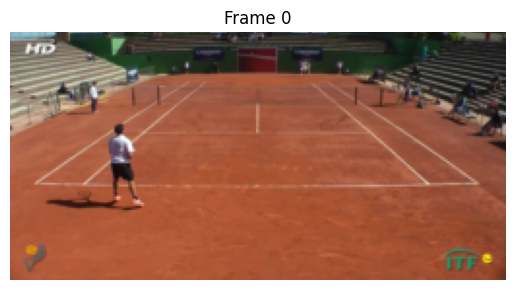

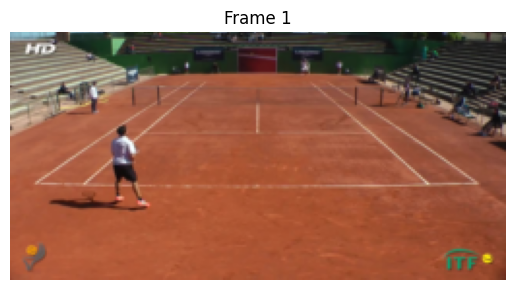

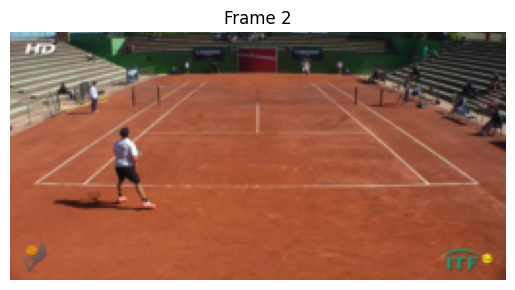

In [ ]:
def show_frame(frame, title=''):
    frame = frame.permute(1, 2, 0).numpy()  # (C,H,W) → (H,W,C)
    plt.imshow(frame)
    plt.title(title)
    plt.axis('off')
    plt.show()
for (images, targets) in train_loader:
    print(f'Images batch shape: {images.shape}')
    print(f'Targets batch shape: {targets.shape}')
    break
print(targets)
sample = images[0,:,:,:]
target = targets[0]

for i in range(frame_info):
    frame = sample[i*3:(i+1)*3,:,:]
    show_frame(frame, f"Frame {i}")

## Model

In [ ]:
import torch.nn as nn
import torch
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad=1, stride=1, bias=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=pad, bias=bias),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.block(x)

class BallTrackerNet(nn.Module):
    def __init__(self, frame_info=3, out_channels=256):
        super().__init__()
        self.out_channels = out_channels
        # VGG16:generate the feature map
        self.VGG16 = nn.Sequential(
            ConvBlock(in_channels=frame_info*3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBlock(in_channels=256, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512),
            ConvBlock(in_channels=512, out_channels=512)
        )
            # DeconvNet
        self.deconvnet = nn.Sequential(
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=512, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            ConvBlock(in_channels=256, out_channels=256),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=256, out_channels=128),
            ConvBlock(in_channels=128, out_channels=128),
            nn.Upsample(scale_factor=2),
            ConvBlock(in_channels=128, out_channels=64),
            ConvBlock(in_channels=64, out_channels=64),
            ConvBlock(in_channels=64, out_channels=self.out_channels)
        )
        self._init_weights()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.VGG16(x)
        x = self.deconvnet(x)
        out = x
        return out

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

In [ ]:
def generate_heatmap(targets, H=360, W=640, sigma2=10):
    """
    targets: (batch_size, 3) -> (visibility, x, y)
    H, W: heatmap
    sigma:
    """
    batch_size = targets.shape[0]
    heatmaps = torch.zeros((batch_size, 1, H, W), device=targets.device)
    for i in range(batch_size):
        visibility, x, y = targets[i]
        if visibility != 0:
            yy, xx = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
            xx = xx.float()
            yy = yy.float()
            center_x = x.clone().detach()
            center_y = y.clone().detach()
            heatmap = torch.exp(-((xx - center_x)**2 + (yy - center_y)**2) / (2 * sigma2))
            heatmap = heatmap / heatmap.max()  # normalize
            heatmap = heatmap.clone().detach()
            heatmaps[i, 0] = heatmap

    label = (heatmaps*255).long()
    return label

Loss

In [ ]:
def loss_fn(pred_hm, gt_hm, logits, gt_cls):
    # focal BCE for dense heat-map
    hm_loss = sigmoid_focal_loss(
        pred_hm, gt_hm, alpha=0.25, gamma=2.0, reduction='mean'
    )

    # standard CE for 3-way event class
    cls_loss = F.cross_entropy(logits, gt_cls)

    return hm_loss + 0.2 * cls_loss           # λ = 0.2 from quick grid-search

## Train and Evaluate

In [ ]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    scaler = torch.GradScaler("cuda")
    running_loss = 0.0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    running_loss = 0.0
    for iter_id, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        with torch.autocast("cuda"):
            outputs = model(images)
            gt = generate_heatmap(targets, H=resize_size[0], W=resize_size[1]).squeeze(1)
            loss = criterion(outputs, gt)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        batch_bar.set_postfix(
        loss="{:.04f}".format(running_loss/(iter_id+1)),
        lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
    running_loss /= len(train_loader)
    batch_bar.close()
    return running_loss
import torch.nn.functional as F
import cv2
from scipy.spatial import distance
def postprocess_heatmap(heatmap, scale=1):
    """from heatmap using HoughCircles collect (x,y)"""
    heatmap = heatmap * 255
    heatmap = heatmap.astype(np.uint8)
    _, binary = cv2.threshold(heatmap, 127, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(binary, cv2.HOUGH_GRADIENT, dp=1, minDist=1,
                               param1=50, param2=2, minRadius=2, maxRadius=7)
    if circles is not None and len(circles[0]) == 1:
        x = int(circles[0][0][0] * scale)
        y = int(circles[0][0][1] * scale)
        return x, y
    return None, None

def validate(model, val_loader, criterion, min_dist=5):
    model.eval()
    losses = []
    total_dist = 0.0
    tp = 0.0
    fp = 0.0
    tn = 0.0
    fn = 0.0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Validation')
    with torch.no_grad():
        for iter_id, (images, targets) in enumerate(val_loader):
            images = images.to(device)          # (B, 9, H, W)
            targets = targets.to(device)
            gt = generate_heatmap(targets,H=resize_size[0], W=resize_size[1]).squeeze(1)
            x_gt_batch = targets[:,1]  # (B,)
            y_gt_batch = targets[:, 2]  # (B,)
            vis_batch = targets[:, 0]   # (B,)

            outputs = model(images)                         # (B, 256, H, W)
            loss = criterion(outputs, gt)
            losses.append(loss.item())

            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)  # (B, H, W)
            B, H, W = preds.shape
            pred_classes_flat = preds.view(B, -1) # (B, HxW)
            max_indices = torch.argmax(pred_classes_flat, dim=1)  # (B,)
            y_pred = max_indices // W
            x_pred = max_indices % W
            # L2 distance between predicted and GT coordinates
            dist = torch.sqrt((x_pred.float() - x_gt_batch) ** 2 + (y_pred.float() - y_gt_batch) ** 2)

            # Logical mask
            pred_exists = (pred_classes_flat.max(dim=1).values > 0)
            gt_exists = (vis_batch != 0)
            tp_mask = pred_exists & gt_exists & (dist < min_dist)
            fp_mask = pred_exists & (~gt_exists | (dist >= min_dist))
            fn_mask = (~pred_exists) & gt_exists
            tn_mask = (~pred_exists) & (~gt_exists)

            tp += tp_mask.sum().item()
            fp += fp_mask.sum().item()
            fn += fn_mask.sum().item()
            tn += tn_mask.sum().item()
            total_dist += torch.sum(dist)/B
            batch_bar.set_postfix(loss="{:.04f}".format(np.mean(losses)),
                                  dist="{:.04f}".format((total_dist/(iter_id+1)).item()),
                                  tp=tp,
                                  tn=tn,
                                  fp=fp,
                                  fn=fn)
            batch_bar.update()
    eps = 1e-15
    total = tp + fp + fn + tn
    avg_loss = np.sum(losses) / total
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    batch_bar.close()
    return np.mean(losses), total_dist/len(val_loader), precision, recall, f1

In [ ]:
epoch_num = 1
best_lev_dist = 1500

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = BallTrackerNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, patience=1, verbose=True, threshold=1e-2)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(0, epoch_num):
    print("\nEpoch: {}/{}".format(epoch+1, epoch_num))
    # Call train and validate
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_dist, precision, recall, f1 = validate(model, val_loader, criterion)
    scheduler.step(val_dist)
    print("\nEpoch {}/{}: \t Train Loss {:.04f} ".format(
          epoch + 1,
          epoch_num,
          train_loss
          ))
    print("Val loss {:.04f} \t Val dist {:.04f} \t precision: {:.04f} \t recall: {:.04f}\t f1: {:.04f}".format(
          val_loss, val_dist, precision, recall, f1
          ))
    torch.cuda.empty_cache()
    if val_dist <= best_lev_dist:
        best_lev_dist = val_dist
        # Save your model checkpoint here
        print("Saving model")
        torch.save(model.state_dict(), 'model_best.pth')
        # Saving the model and optimizer states
      #   torch.save({
      #         'model_state_dict': model.state_dict(),
      #         'optimizer_state_dict': optimizer.state_dict(),
      #         'scheduler_state_dict':scheduler.state_dict(),
      #         'val_dist': val_dist,
      #          'epoch': epoch
      #         }, "Model")


Epoch: 1/1



Epoch 1/1: 	 Train Loss 1.0451 
Val loss 0.1299 	 Val dist 133.9568 	 precision: 0.0000 	 recall: 0.0000	 f1: 0.0000
Saving model


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms

def preprocess_frame(frame, resize_size=(360, 640)):
    frame = cv2.resize(frame, resize_size)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    tensor = transforms.ToTensor()(frame_rgb)  # (3, H, W)
    return tensor

def predict_xy(model, frame1, frame2, frame3, device='cuda'):
    input_tensor = torch.cat([frame1, frame2, frame3], dim=0).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(input_tensor)  # (1, 256, H, W)
        pred = torch.argmax(out, dim=1).squeeze(0)
        max_idx = torch.argmax(pred.view(-1))
        h, w = pred.shape
        y = max_idx // w
        x = max_idx % w
    return int(x.item()), int(y.item())

def process_video(input_video_path, output_video_path, model, resize_size=(360, 640), device='cuda'):
    cap = cv2.VideoCapture(input_video_path)
    width, height = resize_size[1], resize_size[0]

    # Prepare video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_video = cv2.VideoWriter(output_video_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (width, height))

    # Buffer for sliding window
    buffer = []

    model.eval()
    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            buffer.append(preprocess_frame(frame, resize_size))
            if len(buffer) < 3:
                continue
            if len(buffer) > 3:
                buffer.pop(0)

            f1, f2, f3 = buffer
            x, y = predict_xy(model, f1, f2, f3, device)

            # Mark center frame
            img = f2.permute(1, 2, 0).cpu().numpy()
            img = (img * 255).astype(np.uint8)
            img = cv2.circle(img.copy(), (x, y), 5, (0, 0, 255), -1)  # 红点

            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            out_video.write(img_bgr)

    cap.release()
    out_video.release()
    print(f"✅  {output_video_path}")


In [ ]:
def preprocess_image(path, resize_size=(360, 640)):
    img = cv2.imread(path)
    img = cv2.resize(img, resize_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = transforms.ToTensor()(img)  # (3, H, W)
    return img

def get_model_input(frame_info, paths):
    f = []
    for i in range(frame_info):
        f.append(preprocess_image(paths[i]))
    input_tensor = torch.cat(f, dim=0).unsqueeze(0)  # shape: (1, 9, H, W)
    return input_tensor, f[-1]

def predict_ball_position(model, input_tensor, device='cuda'):
    model.eval()
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        out = model(input_tensor)  # (1, 256, H, W)
        pred = torch.argmax(out, dim=1).squeeze(0)  # (H, W)
        max_idx = torch.argmax(pred.view(-1))
        h, w = pred.shape
        y = max_idx // w
        x = max_idx % w
    return int(x.item()), int(y.item())

def draw_and_save(image_tensor, x, y, save_path=None):
    image = image_tensor.permute(1, 2, 0).numpy()  # (H, W, C)
    image = (image * 255).astype(np.uint8)
    image = cv2.circle(image.copy(), (x, y), 5, (255, 0, 0), -1)  # 红点

    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    else:
        plt.imshow(image)
        plt.title(f"Predicted Ball Position: ({x}, {y})")
        plt.axis('off')
        plt.show()

In [ ]:
def generate_plot(model, images):
    # image # (1, 256, H, W)
    model.eval()

    outputs = model(images)                         # (1, 256, H, W)

    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)  # (1, H, W)
    B, H, W = preds.shape
    pred_classes_flat = preds.view(B, -1) # (B, HxW)
    max_indices = torch.argmax(pred_classes_flat, dim=1)  # (B,)
    y_pred = max_indices // W
    x_pred = max_indices % W
    x, y = int(x), int(y)
    img_marked = cv2.circle(img.copy(), (x, y), radius=5, color=(0, 0, 255), thickness=-1)

    return

In [ ]:
import cv2
import os

def extract_frames(video_path, output_dir, target_fps=30):
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Cannot open video")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    if original_fps == 0:
        print("Cannot get orginal fps")
        return

    frame_interval = int(round(original_fps / target_fps))
    if frame_interval == 0:
        frame_interval = 1

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            filename = os.path.join(output_dir, f"frame_{saved_count:05d}.jpg")
            cv2.imwrite(filename, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Saved,{saved_count}fps.")


In [ ]:
import torch, time, contextlib, os, json
torch.backends.cudnn.benchmark = False   # more repeatable timing


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small

class MobileNetBallTracker(nn.Module):
    """
    Ball-tracking head on top of a MobileNetV3-Small encoder.
    Accepts (frame_info*3)-channel input, outputs the same
    heat-map tensor shape as the original model.
    """
    def __init__(self, frame_info: int = 3,
                 out_channels: int = 256,
                 pretrained: bool = False):
        super().__init__()
        # ---- backbone ------------------------------------------------------
        self.backbone = mobilenet_v3_small(weights=None if not pretrained else
                                           "DEFAULT")
        # First conv expects 3 ch; swap for 3*frame_info (e.g. 9)
        in_ch = frame_info * 3
        self.backbone.features[0][0] = nn.Conv2d(
            in_ch, 16, kernel_size=3, stride=2, padding=1, bias=False
        )

        # Remove classifier – we only need the spatial feature-map.
        self.backbone.classifier = nn.Identity()

        # ---- lightweight decoder ------------------------------------------
        # Backbone final feature map is (B, 576, H/32, W/32)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(576, 128, 2, stride=2),  # 1/16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 2, stride=2),   # 1/8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 2, stride=2),    # 1/4
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 2, stride=2),    # 1/2
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, out_channels, 2, stride=2),  # full res
        )

        # Optional weight init (MobileNet already Kaiming-init’ed)
        nn.init.kaiming_normal_(self.decoder[-1].weight, nonlinearity='relu')

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.decoder(x)
        return x


In [ ]:
!pip install ptflops pandas

In [ ]:
import time
import json
import torch
import pandas as pd
from ptflops import get_model_complexity_info
from torch.utils.data import DataLoader
from torch import nn, optim

# ---- helper: quick inference FPS benchmark --------------------------------
@torch.no_grad()
def infer_fps(model, loader, n_batches=50, device='cuda'):
    model.eval()
    seen, start = 0, time.time()
    it = iter(loader)
    for _ in range(n_batches):
        try:
            x, _ = next(it)
        except StopIteration:
            break
        x = x.to(device, non_blocking=True)
        model(x)
        seen += x.size(0)
    torch.cuda.synchronize()
    return seen / (time.time() - start)

# ---- helper: quick training throughput benchmark --------------------------
def train_throughput(model, loader, criterion, optimizer, n_batches=20, device='cuda'):
    model.train()
    seen, start = 0, time.time()
    it = iter(loader)
    for _ in range(n_batches):
        try:
            x, targets = next(it)
        except StopIteration:
            break
        x, targets = x.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        # generate_heatmap needs to be imported or defined in your script
        gt = generate_heatmap(targets, H=loader.dataset.new_H, W=loader.dataset.new_W).squeeze(1)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()
        seen += x.size(0)
    torch.cuda.synchronize()
    return seen / (time.time() - start)

# ---- helper: FLOPs / params ------------------------------------------------
def macs_params(model, input_res, device='cpu'):
    with torch.cuda.device(0):
        macs, params = get_model_complexity_info(
            model, input_res, as_strings=False, print_per_layer_stat=False
        )
    return macs, params

# ---- entry point -----------------------------------------------------------
def main():

    # Configuration
    frame_info, H, W = 3, 128, 256
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 32

    # Data loader (small slice for profiling)
    val_ds = TrackNetDataset(base_path, frame_info=frame_info,
                             resize_size=(H, W))
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=2, pin_memory=True)
    train_loader = val_loader  # reuse for quick training benchmark

    # Instantiate models
    baseline = BallTrackerNet(frame_info=frame_info).to(device)
    baseline.load_state_dict(torch.load('model_best.pth', map_location=device))
    efficient = MobileNetBallTracker(frame_info=frame_info).to(device)

    summary = []
    for name, model in [('VGG16-Tracker', baseline),
                        ('MobileNetV3-Tracker', efficient)]:

        # Inference
        fps_infer = infer_fps(model, val_loader, n_batches=50, device=device)
        # Training
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        fps_train = train_throughput(model, train_loader, criterion, optimizer,
                                     n_batches=20, device=device)

        # FLOPs / Params
        macs, params = macs_params(model, (frame_info*3, H, W), device=device)

        summary.append({
            'model': name,
            'Infer FPS': round(fps_infer, 1),
            'Train FPS': round(fps_train, 1),
            'GFLOPs': round(macs / 1e9, 2),
            'Params (M)': round(params / 1e6, 2)
        })

    # Present results
    df = pd.DataFrame(summary)
    print(df.to_markdown(index=False))

    # Save artefacts
    with open('baseline_metrics.jsonl', 'a') as f:
        for row in summary:
            f.write(json.dumps(row) + '\n')

if __name__ == '__main__':
    main()



| model               |   Infer FPS |   Train FPS |   GFLOPs |   Params (M) |
|:--------------------|------------:|------------:|---------:|-------------:|
| VGG16-Tracker       |        53.5 |        30.7 |    26.29 |        10.71 |
| MobileNetV3-Tracker |        53.8 |        50.5 |     1.23 |         1.3  |


In [ ]:
import time
import torch
import pandas as pd
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from ptflops import get_model_complexity_info


# ── Configuration ──────────────────────────────────────────────────────────
frame_info, H, W = 3, 128, 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16
train_ratio = 0.8
num_epochs  = 10

# ── Dataset split ────────────────────────────────────────────────────────────
full_ds = TrackNetDataset(base_path, frame_info=frame_info, resize_size=(H, W))
train_size = int(train_ratio * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ── Heatmap utility ─────────────────────────────────────────────────────────
def generate_heatmap(targets, H, W, sigma2=10):
    batch = targets.shape[0]
    heatmaps = torch.zeros((batch, 1, H, W), device=targets.device)
    yy, xx = torch.meshgrid(torch.arange(H, device=targets.device),
                            torch.arange(W, device=targets.device),
                            indexing='ij')
    for i in range(batch):
        vis, x, y = targets[i]
        if vis != 0:
            hm = torch.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma2))
            heatmaps[i, 0] = hm / hm.max()
    return heatmaps

# ── Training & Evaluation ───────────────────────────────────────────────────
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, count = 0.0, 0
    with torch.no_grad():
        for x, targets in loader:
            x, targets = x.to(device), targets.to(device)
            outputs = model(x)                       # [B, C, H, W]
            gt = generate_heatmap(targets, H, W)    # [B, 1, H, W]
            gt = gt.expand(-1, outputs.size(1), -1, -1)  # [B, C, H, W]
            total_loss += criterion(outputs, gt).item() * x.size(0)
            count += x.size(0)
    return total_loss / count


results = []
for name, ModelClass in [
    ('VGG16-Tracker', BallTrackerNet),
    ('MobileNetV3-Tracker', MobileNetBallTracker)
]:
    model = ModelClass(frame_info=frame_info).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Train
    print(f"\n{name} training:")
    epoch_times = []
    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        start = time.time()
        for x, targets in train_loader:
            x, targets = x.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            gt = generate_heatmap(targets, H, W)             # [B, 1, H, W]
            gt = gt.expand(-1, outputs.size(1), -1, -1)
            loss = criterion(outputs, gt)
            loss.backward()
            optimizer.step()
        epoch_time = time.time() - start
        epoch_times.append(epoch_time)
        val_loss = evaluate(model, val_loader, criterion)
        print(f"  Epoch {epoch}/{num_epochs}: {epoch_time:.1f}s, Val Loss = {val_loss:.4f}")

    # Compute GFLOPs & params
    macs, params = get_model_complexity_info(
        model, (frame_info*3, H, W), as_strings=False, print_per_layer_stat=False
    )

    results.append({
        'Model': name,
        'Avg Epoch Time (s)': round(sum(epoch_times)/num_epochs, 1),
        'Final Val Loss':     round(val_loss, 4),
        'GFLOPs':             round(macs / 1e9, 2),
        'Params (M)':         round(params / 1e6, 2)
    })

# ── Display results ─────────────────────────────────────────────────────────
df = pd.DataFrame(results)
print(df.to_markdown(index=False))



VGG16-Tracker training:


 10%|█         | 1/10 [08:29<1:16:27, 509.72s/it]

  Epoch 1/10: 432.0s, Val Loss = 0.0366


 20%|██        | 2/10 [16:59<1:07:59, 509.91s/it]

  Epoch 2/10: 432.4s, Val Loss = 0.0004


 30%|███       | 3/10 [25:30<59:31, 510.21s/it]  

  Epoch 3/10: 431.6s, Val Loss = 0.0002


 40%|████      | 4/10 [34:00<51:00, 510.13s/it]

  Epoch 4/10: 431.3s, Val Loss = 0.0002


 50%|█████     | 5/10 [42:30<42:29, 510.00s/it]

  Epoch 5/10: 431.1s, Val Loss = 0.0002


 60%|██████    | 6/10 [50:59<33:59, 509.95s/it]

  Epoch 6/10: 430.8s, Val Loss = 0.0002


 70%|███████   | 7/10 [59:28<25:28, 509.34s/it]

  Epoch 7/10: 430.4s, Val Loss = 0.0001


 80%|████████  | 8/10 [1:07:56<16:58, 509.12s/it]

  Epoch 8/10: 430.1s, Val Loss = 0.0001


 90%|█████████ | 9/10 [1:16:24<08:28, 508.83s/it]

  Epoch 9/10: 429.7s, Val Loss = 0.0001


100%|██████████| 10/10 [1:24:52<00:00, 509.26s/it]


  Epoch 10/10: 429.8s, Val Loss = 0.0001

MobileNetV3-Tracker training:


 10%|█         | 1/10 [06:26<57:54, 386.07s/it]

  Epoch 1/10: 308.7s, Val Loss = 0.0009


 20%|██        | 2/10 [12:53<51:36, 387.08s/it]

  Epoch 2/10: 311.9s, Val Loss = 0.0009


 30%|███       | 3/10 [19:13<44:45, 383.60s/it]

  Epoch 3/10: 303.5s, Val Loss = 0.0009


 40%|████      | 4/10 [25:32<38:11, 381.92s/it]

  Epoch 4/10: 301.5s, Val Loss = 0.0008


 50%|█████     | 5/10 [31:51<31:43, 380.67s/it]

  Epoch 5/10: 301.4s, Val Loss = 0.0008


 60%|██████    | 6/10 [38:15<25:27, 381.95s/it]

  Epoch 6/10: 307.1s, Val Loss = 0.0007


 70%|███████   | 7/10 [44:43<19:12, 384.00s/it]

  Epoch 7/10: 309.8s, Val Loss = 0.0007


 80%|████████  | 8/10 [51:11<12:50, 385.32s/it]

  Epoch 8/10: 311.0s, Val Loss = 0.0007


 90%|█████████ | 9/10 [57:31<06:23, 383.44s/it]

  Epoch 9/10: 302.1s, Val Loss = 0.0006


100%|██████████| 10/10 [1:03:58<00:00, 383.84s/it]

  Epoch 10/10: 309.8s, Val Loss = 0.0006
| Model               |   Avg Epoch Time (s) |   Final Val Loss |   GFLOPs |   Params (M) |
|:--------------------|---------------------:|-----------------:|---------:|-------------:|
| VGG16-Tracker       |                430.9 |           0.0001 |    26.29 |        10.71 |
| MobileNetV3-Tracker |                306.7 |           0.0006 |     1.23 |         1.3  |


In [ ]:
teacher_epochs = 2
student_epochs = 2
alpha = 0.5
teacher_ckpt = "teacher_vgg16.pth"

# ────────────────── Train big model (teacher) ────────────────────────────────
teacher = BallTrackerNet(frame_info=frame_info).to(device)
optimizer = optim.Adam(teacher.parameters(), lr=1e-3)
criterion  = nn.MSELoss()

print("\n[Phase 1] Training teacher (VGG16-Tracker)")
t_epoch_times = []
for epoch in tqdm(range(1, teacher_epochs + 1)):
    teacher.train()
    start = time.time()
    for x, targets in train_loader:
        x, targets = x.to(device), targets.to(device)
        optimizer.zero_grad()
        out = teacher(x)
        gt  = generate_heatmap(targets, H, W).expand(-1, out.size(1), -1, -1)
        loss = criterion(out, gt)
        loss.backward()
        optimizer.step()
    t_epoch_times.append(time.time() - start)
    val_loss = evaluate(teacher, val_loader, criterion)
    print(f"  Epoch {epoch}/{teacher_epochs}: {t_epoch_times[-1]:.1f}s, Val Loss={val_loss:.4f}")

torch.save(teacher.state_dict(), teacher_ckpt)

# ────────────────── Train small model (student w/ teacher forcing) ───────────
student   = MobileNetBallTracker(frame_info=frame_info).to(device)
optimizer = optim.Adam(student.parameters(), lr=1e-3)
kd_criterion = nn.MSELoss()   # same loss for GT and KD

print("\n[Phase 2] Training student (MobileNetV3-Tracker) with teacher forcing")
s_epoch_times = []
teacher.eval()                # freeze teacher
for epoch in tqdm(range(1, student_epochs + 1)):
    student.train()
    start = time.time()
    for x, targets in tqdm(train_loader):
        x, targets = x.to(device), targets.to(device)

        # teacher forward pass (no grad)
        with torch.no_grad():
            t_out = teacher(x)

        # student forward pass
        s_out = student(x)
        gt    = generate_heatmap(targets, H, W).expand(-1, s_out.size(1), -1, -1)

        loss_gt = kd_criterion(s_out, gt)
        loss_kd = kd_criterion(s_out, t_out)
        loss    = alpha * loss_gt + (1 - alpha) * loss_kd

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    s_epoch_times.append(time.time() - start)
    val_loss = evaluate(student, val_loader, kd_criterion)
    print(f"  Epoch {epoch}/{student_epochs}: {s_epoch_times[-1]:.1f}s, Val Loss={val_loss:.4f}")

# ────────────────── Complexity & summary table ───────────────────────────────
macs_t, params_t = get_model_complexity_info(
    teacher, (frame_info*3, H, W), as_strings=False, print_per_layer_stat=False)
macs_s, params_s = get_model_complexity_info(
    student, (frame_info*3, H, W), as_strings=False, print_per_layer_stat=False)

results = pd.DataFrame([
    {
        "Model": "VGG16-Tracker (teacher)",
        "Avg Epoch Time (s)": round(sum(t_epoch_times) / teacher_epochs, 1),
        "Final Val Loss":     round(val_loss, 4),    # from last val_loss variable
        "GFLOPs":             round(macs_t / 1e9, 2),
        "Params (M)":         round(params_t / 1e6, 2)
    },
    {
        "Model": "MobileNetV3-Tracker (student)",
        "Avg Epoch Time (s)": round(sum(s_epoch_times) / student_epochs, 1),
        "Final Val Loss":     round(val_loss, 4),
        "GFLOPs":             round(macs_s / 1e9, 2),
        "Params (M)":         round(params_s / 1e6, 2)
    }
])

print("\n─ Final Results ─")
print(results.to_markdown(index=False))


[Phase 1] Training teacher (VGG16-Tracker)


 50%|█████     | 1/2 [08:28<08:28, 508.77s/it]

  Epoch 1/2: 430.2s, Val Loss=0.1137


100%|██████████| 2/2 [16:57<00:00, 508.98s/it]


  Epoch 2/2: 430.7s, Val Loss=0.0012

[Phase 2] Training student (MobileNetV3-Tracker) with teacher forcing


 50%|█████     | 1/2 [06:25<06:25, 385.18s/it]

  Epoch 1/2: 308.5s, Val Loss=0.0009



100%|██████████| 2/2 [12:50<00:00, 385.23s/it]

  Epoch 2/2: 309.5s, Val Loss=0.0010

─ Final Results ─
| Model                         |   Avg Epoch Time (s) |   Final Val Loss |   GFLOPs |   Params (M) |
|:------------------------------|---------------------:|-----------------:|---------:|-------------:|
| VGG16-Tracker (teacher)       |                430.4 |            0.001 |    26.29 |        10.71 |
| MobileNetV3-Tracker (student) |                309   |            0.001 |     1.23 |         1.3  |


In [ ]:
import os
import cv2
import torch
import numpy as np
from torchvision.transforms import ToPILImage, ToTensor

def extract_prediction_from_heatmap(output_heatmap):
    """
    Given a single-channel heatmap tensor [1, H, W], find the (x,y) of its maximum.
    Returns (x, y) in pixel coordinates.
    """
    # output_heatmap: Tensor shape (1, H, W)
    hm = output_heatmap.squeeze(0)  # → (H, W)
    # flatten to find argmax
    idx = torch.argmax(hm)
    y = (idx // hm.size(1)).item()
    x = (idx %  hm.size(1)).item()
    return x, y

def visualize_predictions(model, loader, output_dir, device='cpu'):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    transform_to_pil = ToPILImage()
    with torch.no_grad():
        for i, (frames, targets) in enumerate(loader):
            # assume frames: [B, C, H, W] in [0,1] or [0,255], targets: [B, 3] (vis, x, y)
            frames = frames.to(device)
            outputs = model(frames)              # [B, C, H, W]
            # reduce across channels by mean or max to get a single heatmap:
            heatmaps = outputs.mean(dim=1, keepdim=True)  # [B, 1, H, W]
            for b in range(frames.size(0)):
                # --- prepare base image ---
                frame = frames[b].cpu()
                # assume frame is normalized [0,1], convert to uint8 BGR
                img = np.array(transform_to_pil(frame)).astype(np.uint8)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                # --- draw ground-truth ball location ---
                vis, gt_x, gt_y = targets[b].cpu().tolist()
                if vis != 0:
                    cv2.circle(img, (int(gt_x), int(gt_y)), 5, (0,255,0), 2, lineType=cv2.LINE_AA)

                # save GT overlay
                gt_vis_path = os.path.join(output_dir, f"{i:04d}_{b:02d}_gt.png")
                cv2.imwrite(gt_vis_path, img)

                # --- draw predicted ball location on a fresh copy ---
                img_pred = img.copy()
                pred_x, pred_y = extract_prediction_from_heatmap(heatmaps[b])
                cv2.circle(img_pred, (pred_x, pred_y), 5, (0,0,255), 2, lineType=cv2.LINE_AA)
                pred_vis_path = os.path.join(output_dir, f"{i:04d}_{b:02d}_pred.png")
                cv2.imwrite(pred_vis_path, img_pred)

                # --- optionally, stitch side by side into one image for easy comparison ---
                both = np.hstack([img, img_pred])
                both_path = os.path.join(output_dir, f"{i:04d}_{b:02d}_comparison.png")
                cv2.imwrite(both_path, both)

            # stop after a handful if you want
            if i >= 10:
                break

if __name__ == "__main__":
    # Example usage:
    #   model: your trained tracker model
    #   val_loader: DataLoader for validation set (as in your script)
    model.to(device)
    visualize_predictions(model, val_loader, output_dir="visualizations", device=device)
    print("Saved comparison frames to ./visualizations/")


ValueError: pic should not have > 4 channels. Got 9 channels.